In [14]:
import os
import pandas as pd
from rouge import Rouge

# Load the match analysis data
match_analysis_path = '/Users/jesperpilegaard/Desktop/Superliga 2022-2023/responses2/match_analysis_results_from_matchday_1_to_3.csv'
match_analysis = pd.read_csv(match_analysis_path)

# Function to calculate average response time
def calculate_average_response_time(df):
    if 'Response Time (s)' in df.columns:
        return df['Response Time (s)'].mean()
    else:
        return None

# List all query_result files
query_results_dir = '/Users/jesperpilegaard/Desktop/Superliga 2022-2023/responses2'
query_result_files = [f for f in os.listdir(query_results_dir) if f.startswith('query_results_') and f.endswith('.csv')]

# Initialize the Rouge object
rouge = Rouge()

# Create results directory if it doesn't exist
results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)

# Process each query_result file
for query_file in query_result_files:
    # Load the query results
    query_results_path = os.path.join(query_results_dir, query_file)
    query_results = pd.read_csv(query_results_path)
    
    # Merge with match analysis data
    merged_data = pd.merge(query_results, match_analysis, on='Question')
    
    # Calculate ROUGE scores for each pair of generated and reference texts
    rouge_scores = []
    for i, row in merged_data.iterrows():
        generated_text = row['Answer_x']
        reference_text = row['Answer_y']
        scores = rouge.get_scores(generated_text, reference_text, avg=False)
        rouge_scores.append(scores[0])
    
    # Convert the list of scores into a DataFrame
    rouge_scores_df = pd.json_normalize(rouge_scores)
    
    # Calculate average ROUGE scores
    average_rouge_scores = rouge_scores_df.mean().to_dict()
    
    # Calculate average response time and add it to the results
    avg_response_time = calculate_average_response_time(query_results)
    average_rouge_scores['average_response_time'] = avg_response_time
    
    # Convert the dictionary to a DataFrame for saving
    average_rouge_scores_df = pd.DataFrame([average_rouge_scores])
    
    # Save the average results to a new CSV file in the results folder
    output_path = os.path.join(results_dir, f'average_rouge_scores_{query_file}')
    average_rouge_scores_df.to_csv(output_path, index=False)
    
    print(f"Processed and saved: {output_path}")

Processed and saved: results/average_rouge_scores_query_results_gpt-3.5_multi.csv
Processed and saved: results/average_rouge_scores_query_results_gpt-4_multi.csv
Processed and saved: results/average_rouge_scores_query_results_gpt-4_multi_noprompt.csv
Processed and saved: results/average_rouge_scores_query_results_gpt-4o_multi.csv
Processed and saved: results/average_rouge_scores_query_results_gpt-4o_multi_noprompt.csv
Processed and saved: results/average_rouge_scores_query_results_gpt-3.5_multi_noprompt.csv


In [15]:
import pandas as pd
import os

def merge_csv_files(folder_path):
    # Get all CSV file paths in the specified folder
    file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

    # Initialize an empty list to hold the dataframes
    dataframes = []

    # Loop through each file path
    for file_path in file_paths:
        # Extract the model name from the file name (excluding the extension)
        model_name = os.path.splitext(os.path.basename(file_path))[0]
        # Read the CSV file into a dataframe
        df = pd.read_csv(file_path)
        # Insert a column with the model name at the beginning of the dataframe
        df.insert(0, 'Model', model_name)
        # Append the dataframe to the list
        dataframes.append(df)

    # Concatenate all dataframes into a single dataframe
    merged_df = pd.concat(dataframes, ignore_index=True)

    return merged_df

# Specify the folder containing the CSV files
folder_path = '/Users/jesperpilegaard/Desktop/Superliga 2022-2023/results'

# Merge the CSV files
merged_df = merge_csv_files(folder_path)

# Display the merged dataframe
print(merged_df.head())

# Optionally, save the merged dataframe to a new CSV file
merged_df.to_csv('results/merged_rouge_scores.csv', index=False)

                                               Model  rouge-1.r  rouge-1.p  \
0  average_rouge_scores_query_results_gpt-4o_embe...   0.566612   0.067704   
1         average_rouge_scores_query_results_gpt-3.5   0.634920   0.345029   
2  average_rouge_scores_query_results_gpt-4_embed...   0.400454   0.264454   
3  average_rouge_scores_query_results_gpt-4_noprompt   0.670105   0.373400   
4          average_rouge_scores_query_results_gpt-4o   0.623763   0.193474   

   rouge-1.f  rouge-2.r  rouge-2.p  rouge-2.f  rouge-l.r  rouge-l.p  \
0   0.118079   0.259399   0.020766   0.037127   0.522776   0.062293   
1   0.431866   0.335750   0.160119   0.209408   0.566716   0.311797   
2   0.307395   0.183981   0.129649   0.147944   0.361476   0.246152   
3   0.463536   0.387668   0.213725   0.264851   0.638055   0.356527   
4   0.269038   0.331702   0.080671   0.116503   0.600538   0.189202   

   rouge-l.f  average_response_time  
0   0.108483               9.101542  
1   0.388272               1

In [22]:
import os
import pandas as pd

def merge_documents(ground_truth_path, query_results_folder, output_folder):
    # Load the ground truth dataframe
    ground_truth_df = pd.read_csv(ground_truth_path)

    # Dictionary to store dataframes for each model
    model_dfs = {}

    # List all CSV files in the query results folder
    query_result_files = [f for f in os.listdir(query_results_folder) if f.endswith('.csv')]

    # Read each query result file and append it to the corresponding model list
    for file in query_result_files:
        file_path = os.path.join(query_results_folder, file)
        model_name = file
        if model_name not in model_dfs:
            model_dfs[model_name] = []
        query_result_df = pd.read_csv(file_path)
        model_dfs[model_name].append(query_result_df)

    # Merge each model's dataframes and save to separate files
    for model_name, dfs in model_dfs.items():
        all_query_results_df = pd.concat(dfs, ignore_index=True)
        merged_df = pd.merge(ground_truth_df, all_query_results_df, on='Question', suffixes=('_ground_truth', '_query_result'))
        output_file_path = os.path.join(output_folder, f'merged_results_{model_name}.csv')
        merged_df.to_csv(output_file_path, index=False)

# Paths to the ground truth, query results folder, and output folder
ground_truth_path = '/Users/jesperpilegaard/Desktop/Superliga 2022-2023/responses1/match_analysis_results_natural_language.csv'
query_results_folder = '/Users/jesperpilegaard/Desktop/Superliga 2022-2023/responses1'  # Path to the folder containing your query results
output_folder = '/Users/jesperpilegaard/Desktop/Superliga 2022-2023/merged_responses/'  # Path to the folder where merged results will be saved

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Merge the documents
merge_documents(ground_truth_path, query_results_folder, output_folder)

# List the created files
print("Merged files created in the output folder:")
print(os.listdir(output_folder))


Merged files created in the output folder:
['merged_results_query_results_gpt-4o_multi_noprompt.csv.csv', 'merged_results_query_results_gpt-3.5_noprompt.csv.csv', 'merged_results_query_results_gpt-4o_embedding_50.csv.csv', 'merged_results_query_results_gpt-4_multi.csv.csv', 'merged_results_query_results_gpt-3.5.csv.csv', 'merged_results_match_analysis_results_natural_language.csv.csv', 'merged_results_query_results_gpt-4o_embedding_150.csv.csv', 'merged_results_query_results_gpt-3.5_multi.csv.csv', 'merged_results_query_results_phi3.csv.csv', 'merged_results_query_results_gpt-4o.csv.csv', 'merged_results_query_results_gpt-4_embedding_150.csv.csv', 'merged_results_match_analysis_results_from_matchday_1_to_3.csv.csv', 'merged_results_query_results_gpt-4_multi_noprompt.csv.csv', 'merged_results_query_results_gpt-4.csv.csv', 'merged_results_query_results_gpt-4o_multi.csv.csv', 'merged_results_query_results_gpt-3.5_multi_noprompt.csv.csv', 'merged_results_query_results_gpt-4_noprompt.csv.cs

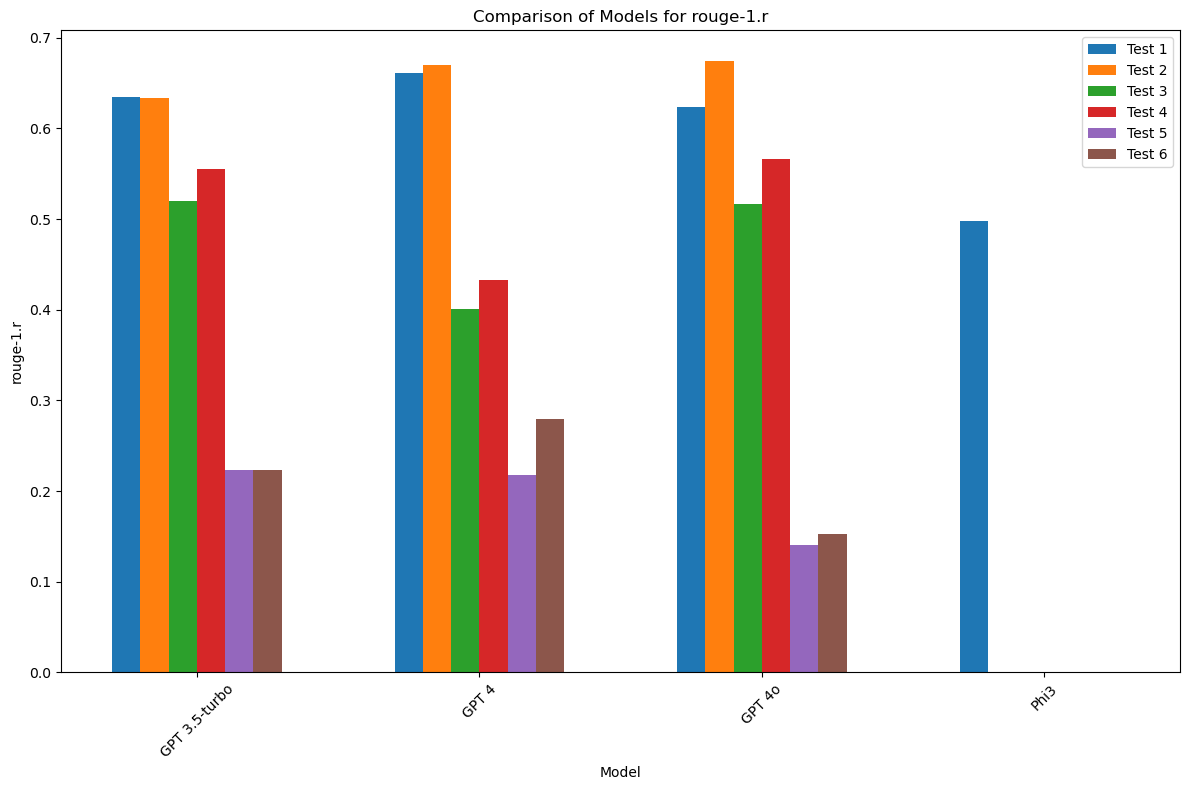

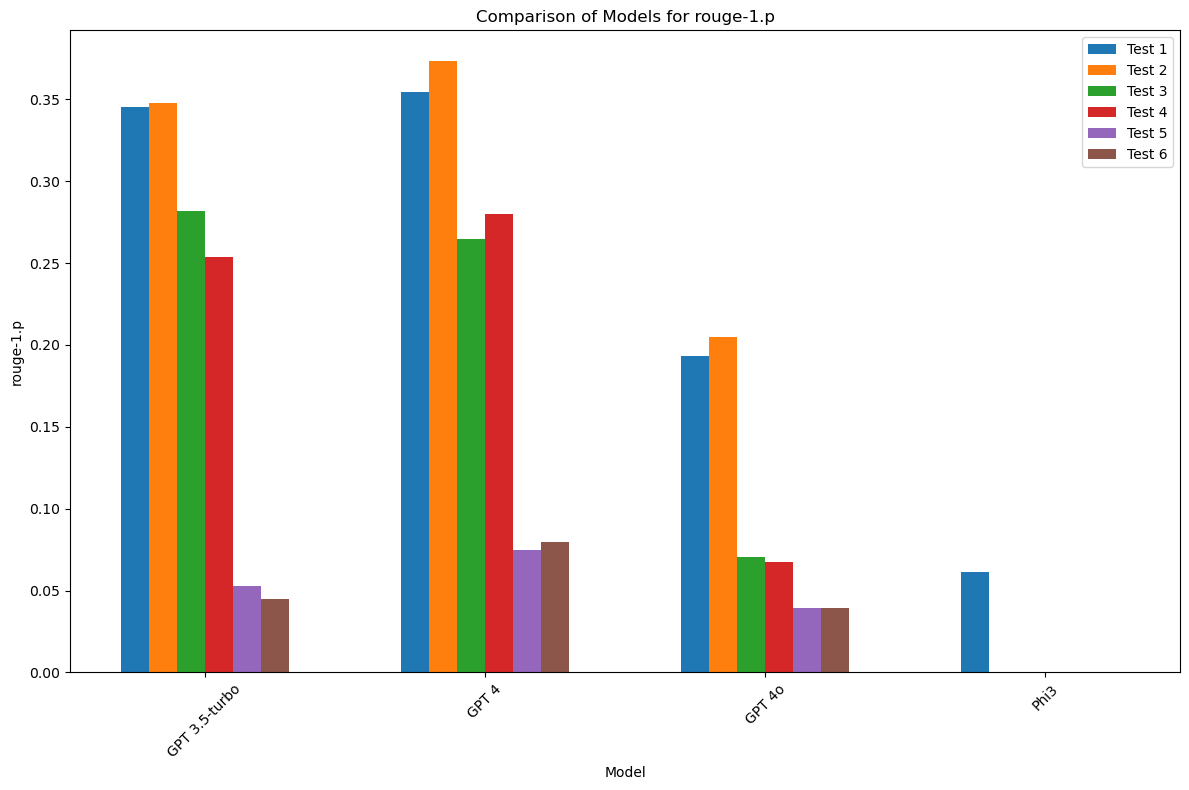

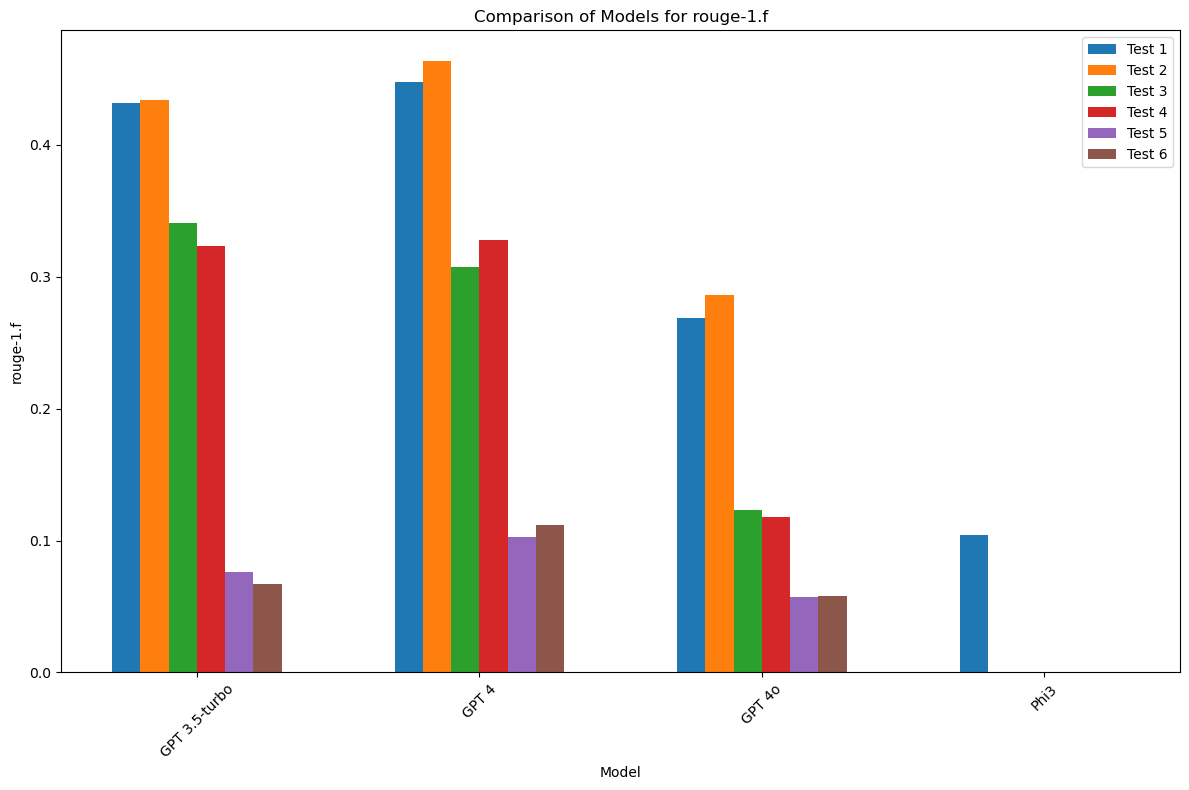

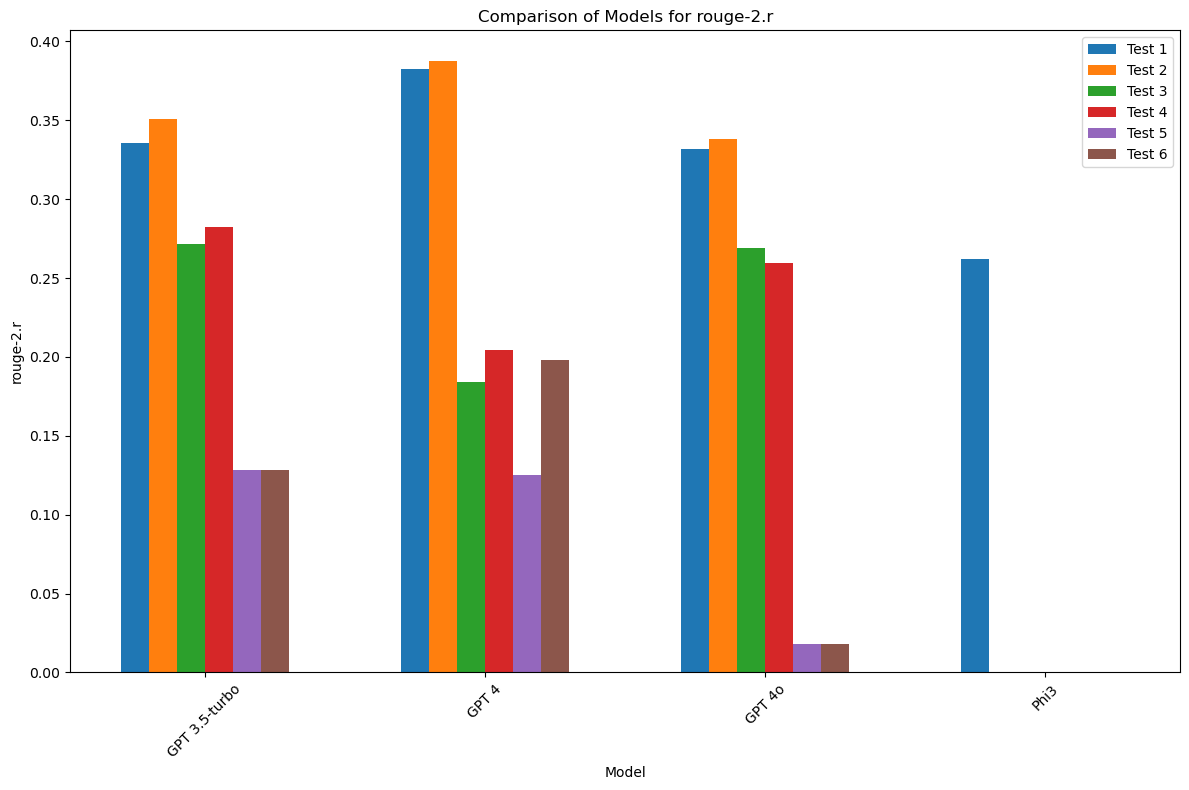

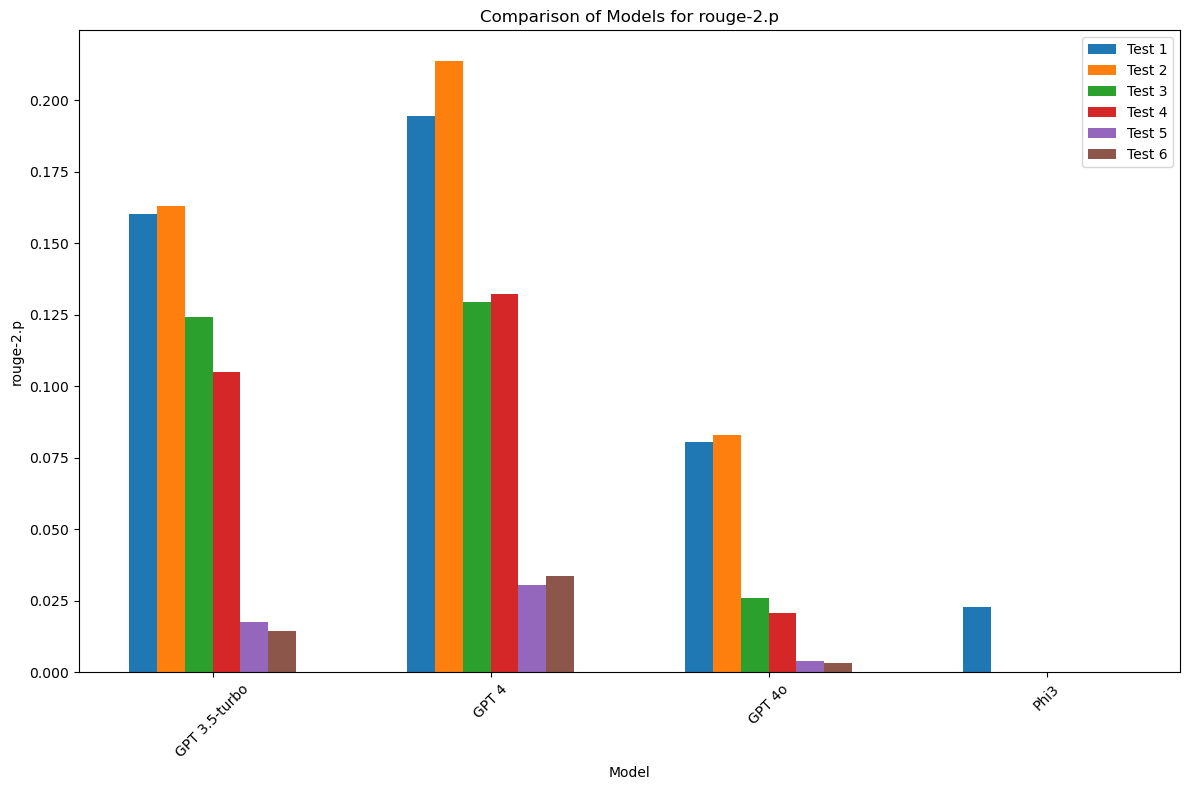

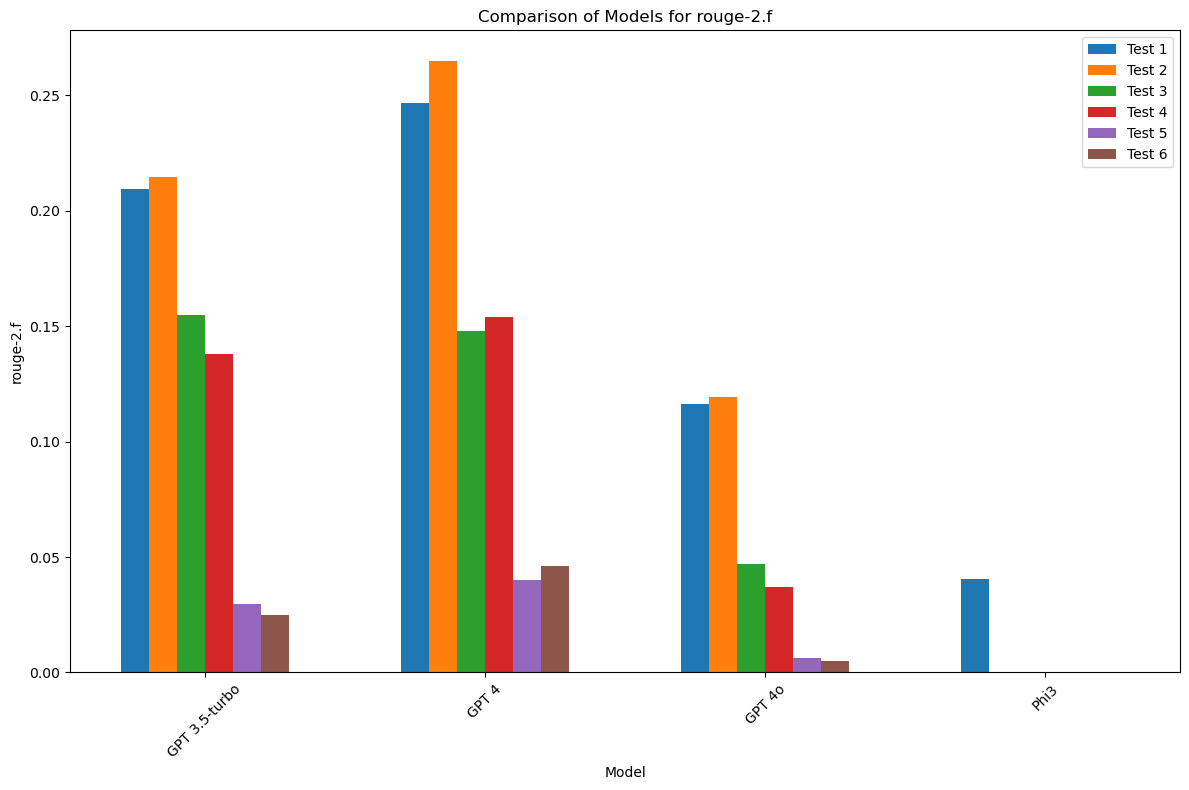

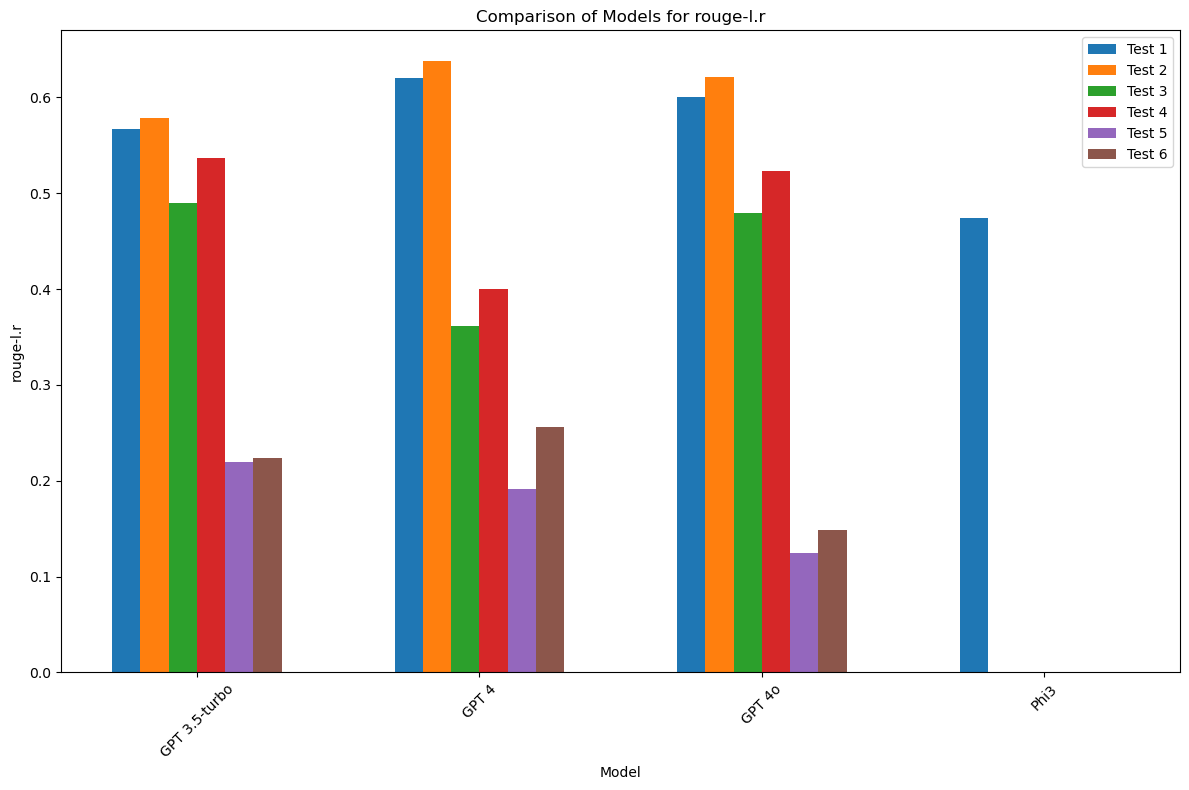

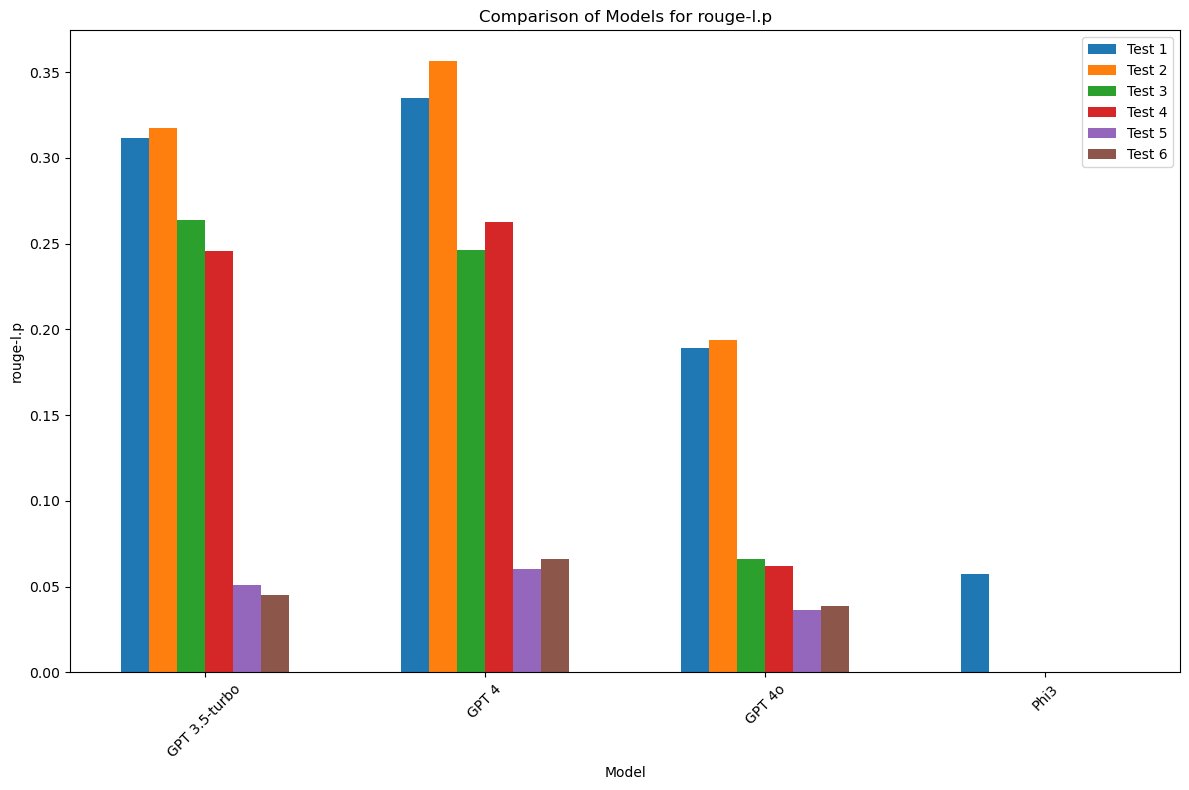

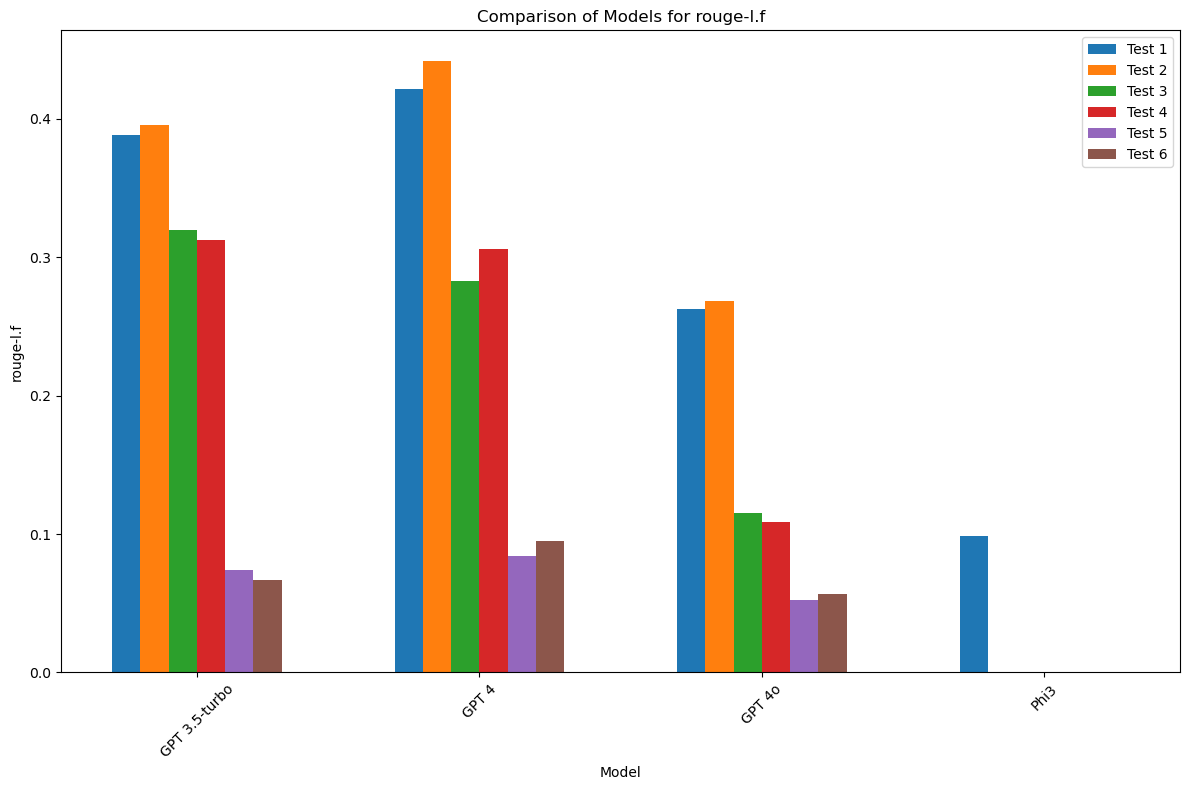

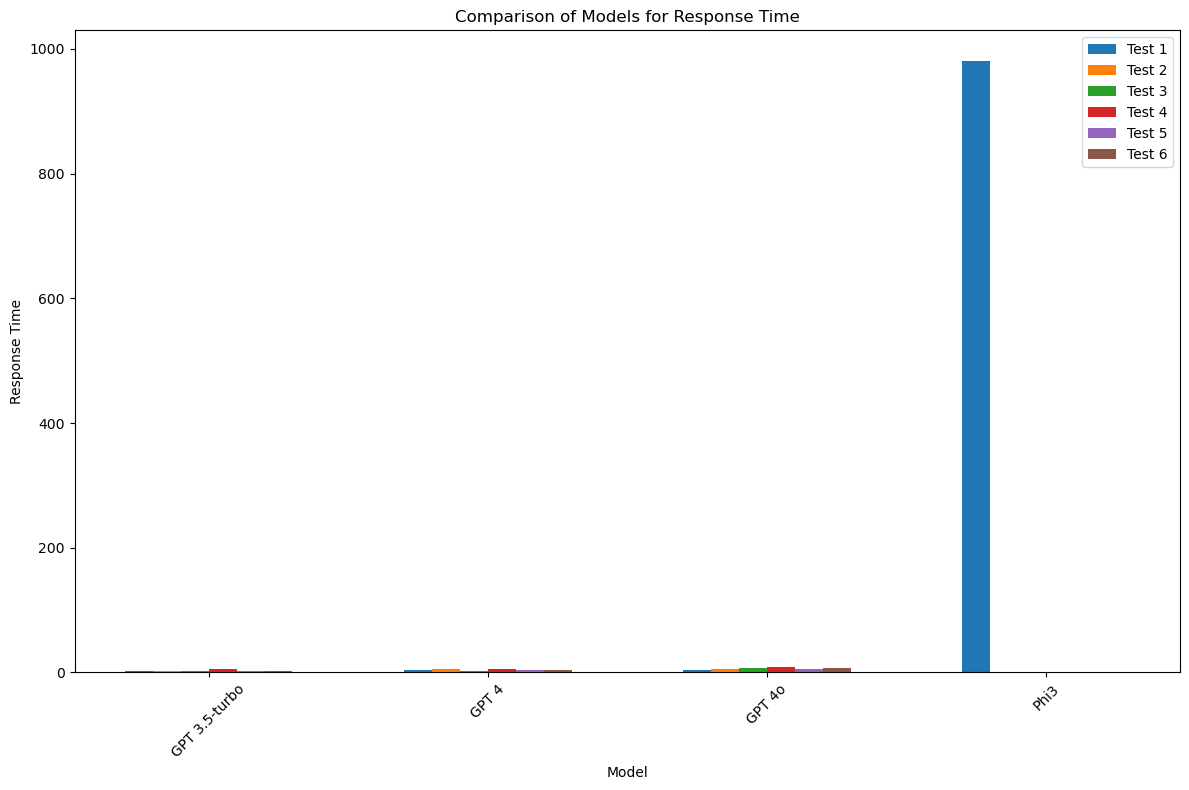

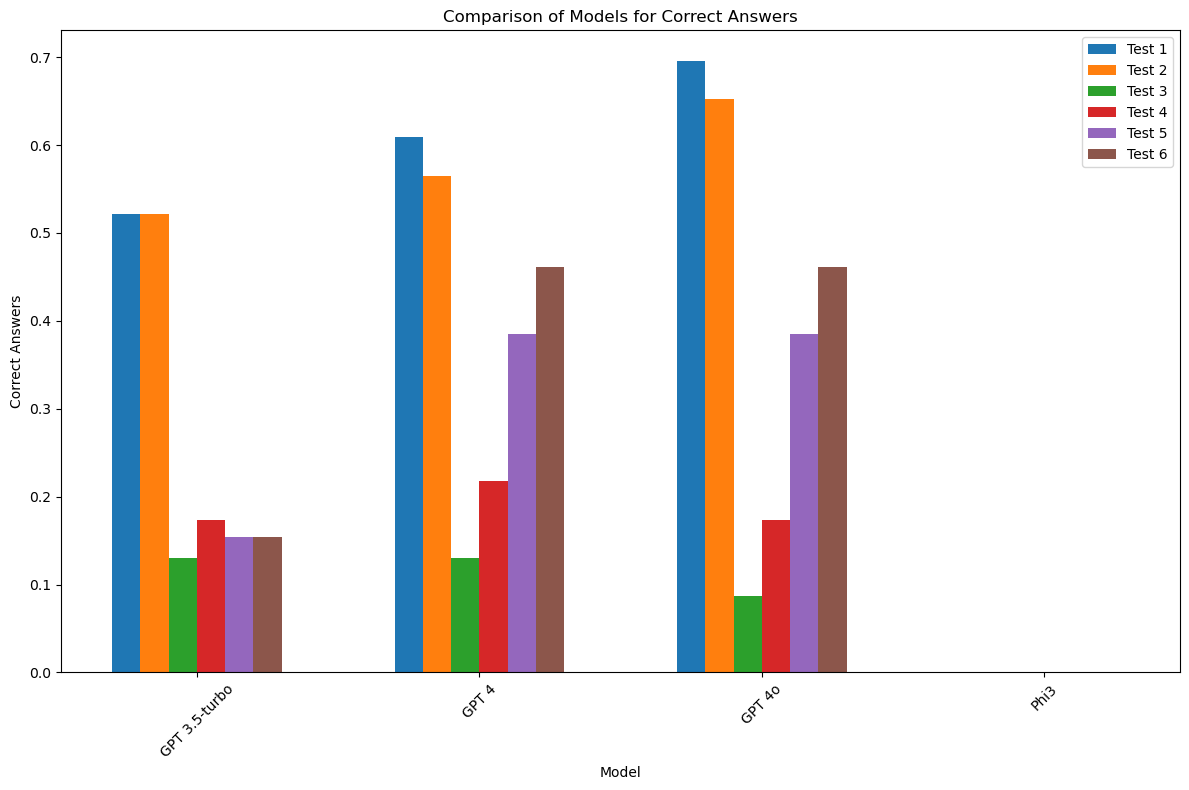

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Creating the DataFrame
data = {
    "Test": [1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6],
    "Model": ["GPT 3.5-turbo", "GPT 4", "GPT 4o", "Phi3", "GPT 3.5-turbo", "GPT 4", "GPT 4o", "GPT 3.5-turbo", "GPT 4", "GPT 4o", 
              "GPT 3.5-turbo", "GPT 4", "GPT 4o", "GPT 3.5-turbo", "GPT 4", "GPT 4o", "GPT 3.5-turbo", "GPT 4", "GPT 4o"],
    "rouge-1.r": [0.6349, 0.6616, 0.6237, 0.4979, 0.6332, 0.6701, 0.6744, 0.5204, 0.4005, 0.5169, 0.5549, 0.4333, 0.5666, 0.2237, 0.2179, 0.1404, 0.2237, 0.2795, 0.1526],
    "rouge-1.p": [0.3450, 0.3543, 0.1934, 0.0611, 0.3476, 0.3734, 0.2049, 0.2815, 0.2645, 0.0708, 0.2534, 0.2801, 0.0677, 0.0526, 0.0748, 0.0395, 0.0449, 0.0797, 0.0394],
    "rouge-1.f": [0.4319, 0.4478, 0.2690, 0.1041, 0.4339, 0.4635, 0.2859, 0.3408, 0.3073, 0.1229, 0.3229, 0.3279, 0.1180, 0.0759, 0.1026, 0.0573, 0.0670, 0.1119, 0.0577],
    "rouge-2.r": [0.3358, 0.3823, 0.3317, 0.2619, 0.3505, 0.3876, 0.3379, 0.2713, 0.1839, 0.2692, 0.2823, 0.2047, 0.2593, 0.1286, 0.1253, 0.0182, 0.1286, 0.1983, 0.0182],
    "rouge-2.p": [0.1601, 0.1946, 0.0807, 0.0230, 0.1631, 0.2137, 0.0830, 0.1243, 0.1296, 0.0261, 0.1049, 0.1321, 0.0208, 0.0176, 0.0305, 0.0039, 0.0144, 0.0337, 0.0032],
    "rouge-2.f": [0.2094, 0.2466, 0.1165, 0.0403, 0.2146, 0.2649, 0.1195, 0.1549, 0.1479, 0.0469, 0.1381, 0.1540, 0.0371, 0.0296, 0.0399, 0.0061, 0.0248, 0.0462, 0.0049],
    "rouge-l.r": [0.5667, 0.6203, 0.6005, 0.4740, 0.5787, 0.6380, 0.6210, 0.4894, 0.3615, 0.4794, 0.5368, 0.4004, 0.5228, 0.2198, 0.1910, 0.1250, 0.2237, 0.2564, 0.1487],
    "rouge-l.p": [0.3118, 0.3347, 0.1892, 0.0576, 0.3174, 0.3565, 0.1940, 0.2639, 0.2462, 0.0664, 0.2456, 0.2627, 0.0623, 0.0511, 0.0604, 0.0363, 0.0449, 0.0662, 0.0386],
    "rouge-l.f": [0.3882, 0.4217, 0.2622, 0.0983, 0.3956, 0.4417, 0.2685, 0.3197, 0.2829, 0.1151, 0.3121, 0.3059, 0.1085, 0.0737, 0.0842, 0.0521, 0.0670, 0.0952, 0.0564],
    "Response Time": [1.6673, 4.7836, 4.4751, 980.5208, 1.6993, 4.9379, 5.6741, 1.8090, 2.7349, 7.9899, 5.2569, 4.8189, 9.1015, 2.1190, 3.6258, 5.6609, 2.2232, 3.3577, 6.6758],
    "Correct Answers": [0.5217, 0.6086, 0.6957, 0, 0.5217, 0.5652, 0.6522, 0.1304, 0.1304, 0.0870, 0.1739, 0.2174, 0.1739, 0.1538, 0.3846, 0.3846, 0.1538, 0.4615, 0.4615]
}

df = pd.DataFrame(data)

# Plotting
metrics = ["rouge-1.r", "rouge-1.p", "rouge-1.f", "rouge-2.r", "rouge-2.p", "rouge-2.f", "rouge-l.r", "rouge-l.p", "rouge-l.f", "Response Time", "Correct Answers"]

for metric in metrics:
    plt.figure(figsize=(12, 8))
    bar_width = 0.1  # Width of the bars
    models = df['Model'].unique()
    tests = df['Test'].unique()
    bar_positions = np.arange(len(models))  # Base positions for bars
    
    # Create a new DataFrame to ensure all models have values for all tests
    pivot_df = df.pivot_table(index='Model', columns='Test', values=metric).reindex(models).fillna(0)
    
    for i, test in enumerate(tests):
        plt.bar(bar_positions + i * bar_width, pivot_df[test], width=bar_width, label=f'Test {test}')
    
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.title(f'Comparison of Models for {metric}')
    plt.xticks(bar_positions + bar_width * (len(tests) - 1) / 2, models, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()